In [72]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [73]:
#Let's get the data
def load_data(path="../data/train.tsv", length=5020):
    df = pd.read_csv(path, sep="\t")[:length]
    df.drop(['PhraseId','SentenceId'], axis=1, inplace=True)
    x, y = df["Phrase"].values, df["Sentiment"].values
    return (x, y)

x, y = load_data("../data/train.tsv")

def clean_text(x, y):
    x = [i.lower() for i in x]
    x = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x]
    x_, y_ = [], []
    for i in range(len(x)):
      if x[i].split():
        x_.append(x[i])
        y_.append(y[i])
    return x_, y_

x, y = clean_text(x, y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print(len(x), len(x_train), len(x_val))
print(x[:5], y[:5])

5000 4000 1000
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story ', 'a series of escapades demonstrating the adage that what is good for the goose', 'a series', 'a', 'series'] [1, 2, 2, 2, 2]


In [74]:
#Simple Dict for embedding
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2idx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2idx)

word2idx['<pad>] = pad_idx

vocab_size = len(word2idx)

n_classes = 5

print(len(word2idx))


1459


In [81]:
#Build datalodaer
batch_size = 400

class mydataset(torch.utils.data.Dataset):
    def __init__(self, x:torch.Tensor, y:torch.Tensor, length_list):
        self.x = x
        self.y = y
        self.length_list = length_list
    def __getitem__(self, index):
        data = self.x[index]
        labels = self.y[index]
        length = self.length_list[index]
        return data, labels, length
    def __len__(self):
        return len(self.x)

def get_idx(word):
    try:
        return word2idx[word]
    except:
        return word2idx['<unknown>']

def sentence2vector(sentence):
    return [get_idx(word) for word in sentence.split()]

def padding(x, max_length):
    length = 0
    for i in range(max_length - len(x)):
        x.append(word2idx['<pad>])
    return x

def get_dataloader(x, y):
    inputs = [sentence2vector(s) for s in x]

    length_list = [len(i) for i in inputs]

    max_length = max(length_list)

    inputs = torch.tensor([padding(s, max_length) for s in inputs])

    targets =  torch.tensor(y, dtype=torch.long)

    dataset = mydataset(inputs, targets, length_list)

    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)

    return dataloader


train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_val, y_val)


In [90]:

class CNN(nn.Module):
    def __init__(self, input_size, embedding_dim, kernel_wins, num_class, embedding):
        super(CNN, self).__init__()
        if embedding is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, max_norm=True, padding_idx=pad_idx)
        else:
            self.embedding = embedding
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, 100, size) for size in kernel_wins])
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(len(kernel_wins)*embedding_dim, num_class)

    def forward(self, x):
        embeded_x = self.embedding(x)

        embeded_x = embeded_x.transpose(1, 2)
        con_x = [conv(embeded_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]
        
        fc_x = torch.cat(pool_x, dim=1)

        fc_x = self.dropout(fc_x)

        fc_x = fc_x.squeeze(-1)

        logit = self.fc(fc_x)
        return logit


In [91]:
def test_model():
    net = CNN(input_size=vocab_size, embedding_dim=100, kernel_wins=[3,4,5], num_class=5, embedding=None)

    loss_function = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.01)

    for i, (inputs, targets, _) in enumerate(train_dataloader):
        net.zero_grad()
    
        print(inputs.shape)

        probs = net(inputs)

        print(probs, targets)

        loss = loss_function(probs, targets)

        loss.backward()

        optimizer.step()
        break

test_model()


torch.Size([400, 39])
tensor([[-0.0798,  0.0610, -0.0230,  0.0272,  0.0375],
        [-0.0154,  0.0489, -0.0094,  0.0267,  0.1848],
        [-0.0911, -0.0032,  0.0262,  0.0504, -0.0544],
        ...,
        [-0.0926,  0.0051, -0.0623,  0.0222, -0.0360],
        [-0.1018,  0.0399,  0.0804,  0.0094, -0.0151],
        [-0.0656,  0.0091, -0.0191, -0.0289, -0.0267]],
       grad_fn=<AddmmBackward>) tensor([2, 2, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 3, 3, 2, 3, 0, 2, 3, 2, 2,
        2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 1, 1, 3, 2, 3, 2, 2, 2, 4,
        2, 2, 3, 3, 2, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 2, 2, 4, 4, 2, 3, 2, 3, 2,
        2, 3, 2, 2, 1, 2, 0, 2, 3, 3, 2, 2, 4, 2, 2, 1, 3, 2, 4, 4, 2, 2, 0, 1,
        2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 1, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 1, 3, 2, 3, 2, 3, 2, 1, 4, 3, 4, 1, 3,
        2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 4, 3, 4, 2,
        2, 1, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2

In [92]:
#Train
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

def train():
    
    criterion =  nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.005)

    epoch = 10

    start_time = time.time()

    loss_list = []

    for i in range(epoch):
        total_loss = 0.
        for j, (inputs, targets, _) in enumerate(train_dataloader):
            probs = net(inputs)

            net.zero_grad()
  
            loss = criterion(probs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            if (j+1) % 5 == 0 and j:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "batch: ", round(j * batch_size), " time: ", pretty_time(time_past), "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()

epoch:  0 batch:  1600  time:  1.4 loss:  7.386471152305603
epoch:  0 batch:  3600  time:  2.6 loss:  6.329024314880371
epoch:  1 batch:  1600  time:  3.9 loss:  5.5275914669036865
epoch:  1 batch:  3600  time:  5.2 loss:  4.978252828121185
epoch:  2 batch:  1600  time:  6.3 loss:  4.347757995128632
epoch:  2 batch:  3600  time:  7.4 loss:  3.857372283935547
epoch:  3 batch:  1600  time:  8.6 loss:  3.3186243772506714
epoch:  3 batch:  3600  time:  9.9 loss:  2.9664178490638733
epoch:  4 batch:  1600  time:  11.5 loss:  2.6680822372436523
epoch:  4 batch:  3600  time:  13.0 loss:  2.514694184064865
epoch:  5 batch:  1600  time:  14.3 loss:  2.1905131340026855
epoch:  5 batch:  3600  time:  15.5 loss:  2.0546429455280304
epoch:  6 batch:  1600  time:  16.7 loss:  1.913691520690918
epoch:  6 batch:  3600  time:  17.9 loss:  1.8895400166511536
epoch:  7 batch:  1600  time:  19.1 loss:  1.7627893686294556
epoch:  7 batch:  3600  time:  20.3 loss:  1.7048624455928802
epoch:  8 batch:  1600 

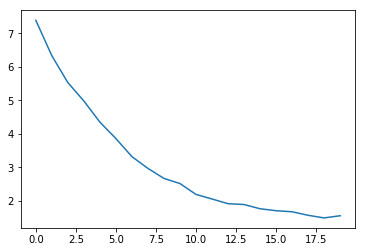

In [94]:
net = CNN(input_size=vocab_size, embedding_dim=100, kernel_wins=[3,4,5], num_class=5, embedding=None)

train()

In [97]:
def test():
    count = 0
    i = 0
    from collections import Counter
    with torch.no_grad():
        for j, (inputs, targets, _) in enumerate(test_dataloader):
            probs = net(inputs)
            count += Counter((torch.argmax(probs, dim=1) - targets).tolist())[0]
            i = j
    print("acc_val: ", count / (j*batch_size))
    distribution = Counter(y_val)
    print(distribution)
    print([i/len(y_val) for i in distribution.values()])


In [98]:
#test 
test()

acc_val:  0.77375
Counter({2: 586, 3: 179, 1: 156, 4: 51, 0: 28})
[0.179, 0.586, 0.156, 0.051, 0.028]


In [99]:
#get the pre-trained glove embedding vectors
EMBEDDING_SIZE = 100

def read_glove(path):
    #the function copied from yjqiang
    embedding = []
    word2id = {}
    with open(path, 'r', encoding='UTF-8') as f:
        for index, line in enumerate(f):
            line = line.rstrip('\n')  # remove the newline character
            if line:  # 移除空白行
                list_line = line.split()
                embedding.append([float(value) for value in list_line[1:]])
                word2id[list_line[0]] = index  # word = list_line[0]
    return embedding, word2id


list_embedding, word2idx = read_glove("../data/glove.6B.100d.txt")

In [100]:
# build dict & handle unknown word

pad_idx = len(list_embedding)
list_embedding.append(torch.zeros(EMBEDDING_SIZE, dtype=torch.float).tolist())
word2idx['padding'] = pad_idx

unk_idx = len(word2idx)
word2idx['unknown'] = unk_idx

vocab_size = len(word2idx)

tensor_embedding = torch.tensor(list_embedding)
EMBEDDING = nn.Embedding.from_pretrained(tensor_embedding, freeze=False, padding_idx=pad_idx)

In [101]:
#get dataloader
train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_val, y_val)

epoch:  0 batch:  1600  time:  9.1 loss:  7.1347938776016235
epoch:  0 batch:  3600  time:  13.8 loss:  5.711783289909363
epoch:  1 batch:  1600  time:  18.9 loss:  4.969871461391449
epoch:  1 batch:  3600  time:  23.5 loss:  4.554324269294739
epoch:  2 batch:  1600  time:  28.2 loss:  4.016790330410004
epoch:  2 batch:  3600  time:  32.8 loss:  3.74507999420166
epoch:  3 batch:  1600  time:  37.4 loss:  3.4401751160621643
epoch:  3 batch:  3600  time:  42.0 loss:  3.2825095653533936
epoch:  4 batch:  1600  time:  46.5 loss:  2.9767150282859802
epoch:  4 batch:  3600  time:  51.4 loss:  2.923047363758087
epoch:  5 batch:  1600  time:  55.9 loss:  2.826662689447403
epoch:  5 batch:  3600  time:  1m0.5 loss:  2.7243958711624146
epoch:  6 batch:  1600  time:  1m5.1 loss:  2.537211239337921
epoch:  6 batch:  3600  time:  1m9.7 loss:  2.590321570634842
epoch:  7 batch:  1600  time:  1m14.3 loss:  2.602447032928467
epoch:  7 batch:  3600  time:  1m19.0 loss:  2.360159933567047
epoch:  8 batc

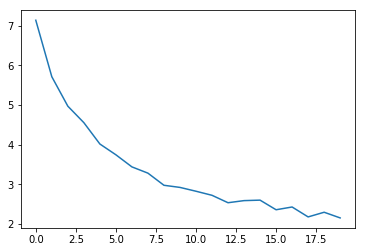

In [102]:
net = CNN(input_size=vocab_size, embedding_dim=100, kernel_wins=[3,4,5], num_class=5, embedding=EMBEDDING)

train()

In [103]:
test()

acc_val:  0.79
Counter({2: 586, 3: 179, 1: 156, 4: 51, 0: 28})
[0.179, 0.586, 0.156, 0.051, 0.028]
